In [1]:
# Import main packages
import sys, os
sys.path.insert(1, os.path.abspath('..') )
from ECO import diagnostics as eco
from ECO.utils import config_parser, open_datasets, get_namelist
import xarray as xr
import xgcm
import numpy as np

# Import matplotlib for plotting and functions to override default values
import matplotlib.pyplot as plt
from plot_utils import update_plotstyle, cmap_OB
cmap_OB=cmap_OB(); update_plotstyle()

from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats

In [2]:
exp_prefix = ['EXP00','EXP01','EXP02'] # Import all files with this prefix
exp_suffix = ['_1m500','_1m500','_1m500']
ds = open_datasets(exp_prefix, exp_suffix, components = ['all'])
if type(ds) != dict: ds={exp_prefix+exp_suffix:ds}

exp0 = 'EXP00_1m500'
exp1 = 'EXP01_1m500'
exp2 = 'EXP02_1m500'

In [3]:
# get base configuration of EXP00
kwargs={}
#kwargs[exp_prefix+exp_suffix] = config_parser(exp_prefix)
for i in range(len(exp_prefix)): kwargs[exp_prefix[i]+exp_suffix[i]] = config_parser(exp_prefix[i])
#for exp in exp_suffix: kwargs[exp_prefix+exp] = config_parser(exp_prefix)
#if kwargs_sim['get_namelist']: kwargs_sim['namelist'] = get_namelist(path = kwargs_proc['path_nemo'])

# define xgcm configuration based on dataset metrics
_metrics = {('X',): ['e1tm', 'e1um', 'e1vm', 'e1fm'],
     ('Y',): ['e2tm', 'e2um', 'e2vm', 'e2fm'],
     ('Z',): ['e3tm', 'e3um', 'e3vm', 'e3wm']}

grid = {exp: xgcm.Grid(ds[exp], metrics=_metrics, periodic=False) for exp in ds} # define xgcm grid
grid_ops = {exp: eco.Grid_ops(grid[exp], maskargs={'mask':'nan'}) for exp in ds} # define gridoperations.
grid = {exp: grid_ops[exp]._update({'Z':ds[exp]['e3tm_1d']}) for exp in ds}
        
properties= {exp: eco.Properties(grid_ops[exp], {'X': ds[exp].glamt, 'Y': ds[exp].gphit, 'Z': ds[exp].depth_1d}, eos_properties=kwargs[exp][2]['eos']) for exp in ds}
energetics= {exp: eco.Energetics(grid_ops[exp], properties[exp]) for exp in ds}

Using processing configuration base.yml
Using processing configuration base.yml
Using processing configuration base.yml


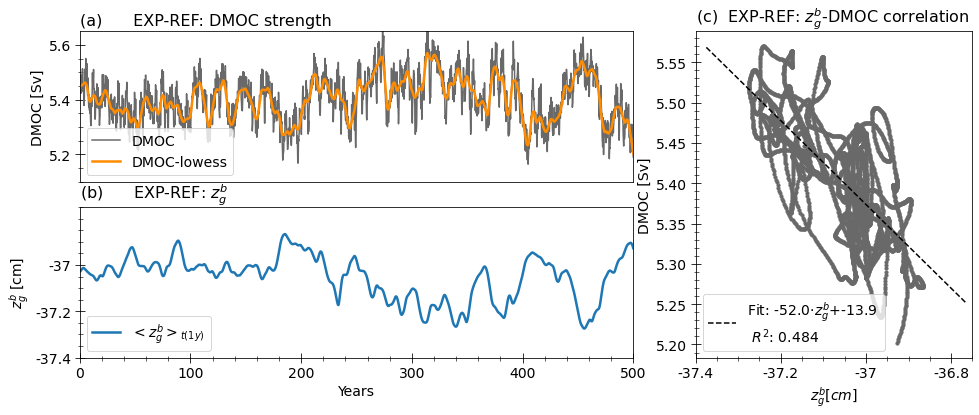

In [35]:
gs_kw = dict(width_ratios=[2,1])
fig, ax = plt.subplots(2,2,figsize=(16,6), gridspec_kw=gs_kw)#,constrained_layout=True)#, gridspec_kw=gs_kw)

gs = ax[0,0].get_gridspec()
for a in ax[:,1]:
    a.remove()
axbig = fig.add_subplot(gs[:,1])

years500=np.linspace(0,500,6000)
mean=12
zg_m = ds[exp0].zgDE.rolling({'t':mean}).mean('t')
DMOC = np.transpose(lowess(ds[exp0].psi_dmoc.values,years500,frac=0.015))[1]
lag=0
cut=slice(int(mean/2)+lag, -(int(mean/2)-1))
cut_r = slice(mean-1,None)

ax[0,0].plot(years500[cut_r][::2],ds[exp0].psi_dmoc.values[cut][::2],
             linewidth=1.5,c='dimgrey',linestyle='-', label='DMOC')
ax[0,0].plot(years500[cut_r],DMOC[cut],linewidth=2.5,c='Darkorange', label='DMOC-lowess')
ax[1,0].plot(years500[cut_r],zg_m[cut_r], label='$<z_g^b>_{t(1y)}$')

ax[1,0].set_xlabel('Years',fontsize=14)
ax[0,0].set_ylabel('DMOC [Sv]',fontsize=14)
ax[1,0].set_ylabel('$z_g^b$ [cm]',fontsize=14)

#ax[0,0].set_ylim(5.95,6.55)
#ax[0,0].set_yticklabels([6,6.1,6.2,6.3,6.4,6.5])
#ax[0,0].set_yticklabels([5.9,6.0,6.1,6.2,6.3,6.4,6.5])

ax[0,0].set_ylim(5.1,5.65)
ax[1,0].set_ylim(-0.374,-0.3675)
#ax[1,0].set_ylim(-0.375,-0.368)
ax[1,0].set_yticks([-0.374,-0.372,-0.37])
ax[1,0].set_yticklabels([-37.4,-37.2,-37])
ax[0,0].set_xlim(0,500)
ax[1,0].set_xlim(0,500)
#ax[1,0].set_xticks([0,600,1200,1800,2400])
#ax[1,0].set_xticklabels([0,50,100,150,200])

ax[0,0].set_xticks([])
ax[0,0].legend(fontsize=14,loc='lower left')
ax[1,0].legend(fontsize=14,loc='lower left')
#ax[0,0].set_xticks([0,600,1200,1800,2400])
#ax[0,0].set_xticklabels([])

lg = stats.linregress(zg_m[cut_r], DMOC[cut])
lg_raw = stats.linregress(zg_m[cut_r], ds[exp0].psi_dmoc.values[cut])
axbig.scatter(zg_m[cut_r],DMOC[cut],s=10,color='Dimgrey')
#axbig.scatter(zg_m[cut],ds[sim[0]].psi_dmoc.values[cut],s=10,color='Dimgrey')
x_const=np.linspace(np.nanmin(zg_m)-.001,
                    np.nanmax(zg_m)+.001,100)
axbig.plot(x_const,lg[0]*x_const+lg[1],linewidth=1.5,c='k',linestyle='--',
           label='Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f'%(lg[0],lg[1],lg[2]**2))
#axbig.plot(x_const,lg[0]*x_const+lg[1],linewidth=1.5,c='k',linestyle='--',
#           label='Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f \n p: %.3f'%(lg[0],lg[1],lg[2]**2,lg[3]))
#axbig.plot(x_const,lg_raw[0]*x_const+lg_raw[1],linewidth=1.5,c='k',linestyle='--',
#           label='LinReg2 r: %.3f \nLinReg2 p: %.3f'%(lg_raw[2]**2,lg_raw[3]))

axbig.set_xlabel('$z_g^b [cm]$',fontsize=14)
axbig.set_ylabel('DMOC [Sv]',fontsize=14)
axbig.legend(fontsize=14,loc='lower left')
axbig.set_xlim(-0.374,-0.3675)
axbig.set_xticks([-0.374,-0.372,-0.37,-0.368])
axbig.set_xticklabels([-37.4,-37.2,-37,-36.8])

ax[0,0].set_title('(a)      EXP-REF: DMOC strength',fontsize=16, loc='left')#, x=-.1)
ax[1,0].set_title('(b)      EXP-REF: $z_g^b$',fontsize=16, loc='left')#, x=-.1)
axbig.set_title('(c)  EXP-REF: $z_g^b$-DMOC correlation',fontsize=16, loc='left')#, x=-.1)

#fig.suptitle('General overturning circulation strength',fontsize=18,y=0.94)

plt.subplots_adjust(wspace=0.15, hspace=0.17)
#plt.savefig('Figures/Fig4_GOCvsZG_REF.png', dpi=150, transparent=True, bbox_inches='tight')

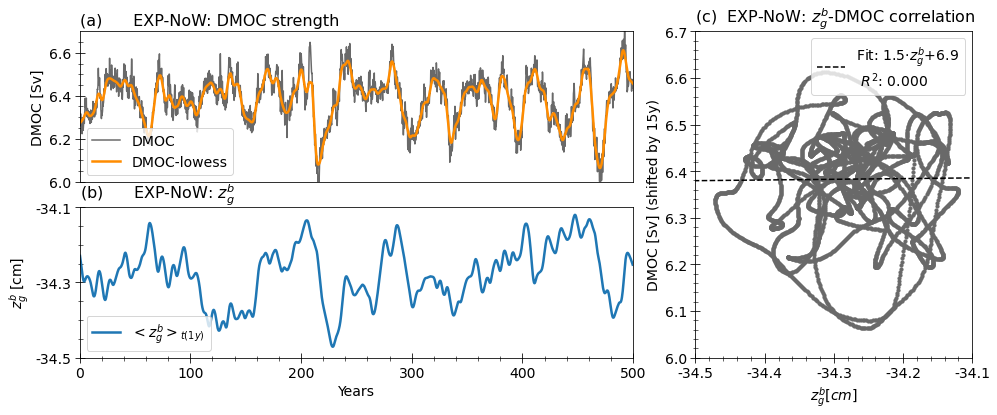

In [39]:
gs_kw = dict(width_ratios=[2,1])
fig, ax = plt.subplots(2,2,figsize=(16,6), gridspec_kw=gs_kw)#,constrained_layout=True)#, gridspec_kw=gs_kw)

gs = ax[0,0].get_gridspec()
for a in ax[:,1]:
    a.remove()
axbig = fig.add_subplot(gs[:,1])

years500=np.linspace(0,500,6000)
mean=12
zg_m = ds[exp1].zgDE.rolling({'t':mean}).mean('t')
y_m = ds[exp1].zgDE.copy(data=years500).rolling({'t':mean}).mean('t')
t_lowess,DMOC = np.transpose(lowess(ds[exp1].psi_dmoc.values,years500,frac=0.015))

lag=0*12
cut=slice(int(mean/2)+lag, -(int(mean/2)-1))
#cut_r = slice(mean-1,-(lag))
cut_r = slice(mean-1,None)

ax[0,0].plot(years500[::2],ds[exp1].psi_dmoc.values[::2],
             linewidth=1.5,c='dimgrey',linestyle='-', label='DMOC')
ax[0,0].plot(t_lowess,DMOC,linewidth=2.5,c='Darkorange', label='DMOC-lowess')
ax[1,0].plot(y_m,zg_m, label='$<z_g^b>_{t(1y)}$')

ax[1,0].set_xlabel('Years',fontsize=14)
ax[0,0].set_ylabel('DMOC [Sv]',fontsize=14)
ax[1,0].set_ylabel('$z_g^b$ [cm]',fontsize=14)

ax[0,0].set_ylim(6.0,6.7)
ax[1,0].set_ylim(-0.345,-0.341)
ax[1,0].set_yticks([-0.345,-0.343,-0.341])
ax[1,0].set_yticklabels([-34.5,-34.3,-34.1])
ax[0,0].set_xlim(0,500)
ax[1,0].set_xlim(0,500)

ax[0,0].set_xticks([])
ax[0,0].legend(fontsize=14,loc='lower left')
ax[1,0].legend(fontsize=14,loc='lower left')
#ax[0,0].set_xticks([0,600,1200,1800,2400])
#ax[0,0].set_xticklabels([])

lg = stats.linregress(zg_m[cut_r], DMOC[cut])
lg_raw = stats.linregress(zg_m[cut_r], ds[exp1].psi_dmoc.values[cut])
axbig.scatter(zg_m[cut_r],DMOC[cut],s=10,color='Dimgrey')
#axbig.scatter(zg_m[cut],ds[sim[0]].psi_dmoc.values[cut],s=10,color='Dimgrey')
x_const=np.linspace(np.nanmin(zg_m)-.001,
                    np.nanmax(zg_m)+.001,100)

axbig.plot(x_const,lg[0]*x_const+lg[1],linewidth=1.5,c='k',linestyle='--',
           label='Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f'%(lg[0],lg[1],lg[2]**2))
#axbig.plot(x_const,lg[0]*x_const+lg[1],linewidth=1.5,c='k',linestyle='--',
#           label='Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f \n p: %.3f'%(lg[0],lg[1],lg[2]**2,lg[3]))
#axbig.plot(x_const,lg_raw[0]*x_const+lg_raw[1],linewidth=1.5,c='k',linestyle='--',
#           label='LinReg2 r: %.3f \nLinReg2 p: %.3f'%(lg_raw[2]**2,lg_raw[3]))

axbig.set_xlabel('$z_g^b [cm]$',fontsize=14)
axbig.set_ylabel('DMOC [Sv] (shifted by 15y)',fontsize=14)
axbig.legend(fontsize=14)
axbig.set_ylim(6.0,6.7)
axbig.set_xlim(-0.345,-0.341)
axbig.set_xticks([-0.345,-0.344,-0.343,-0.342,-0.341])
axbig.set_xticklabels([-34.5,-34.4,-34.3,-34.2,-34.1])

ax[0,0].set_title('(a)      EXP-NoW: DMOC strength',fontsize=16, loc='left')#, x=-.1)
ax[1,0].set_title('(b)      EXP-NoW: $z_g^b$',fontsize=16, loc='left')#, x=-.1)
axbig.set_title('(c)  EXP-NoW: $z_g^b$-DMOC correlation',fontsize=16, loc='left')#, x=-.1)
#fig.suptitle('General overturning circulation strength',fontsize=18,y=0.94)
ax[0,0].arrow(325,7.045,30,0,width=0.04, head_length=7,facecolor='darkgrey')
ax[0,0].annotate('~ 15y lag',(250,7.025),fontsize=14)

plt.subplots_adjust(wspace=0.15, hspace=0.17)
#plt.savefig('Figures/Fig4_GOCvsZG_NOWIND.png', dpi=150, transparent=True, bbox_inches='tight')